# Exercise 1 b
## 3 Nearest Neighbor Classification on Real Data
### 3.1 Exploring the Data

In [1]:
#load dataset from sklearn
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

print(data.dtype)

#check, what is the size of the images
print(images[0].shape)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64
(8, 8)


As we can see the size of the images is 8x8.

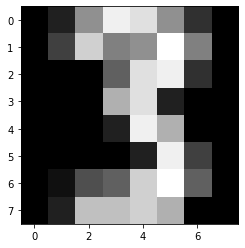

In [2]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

img = images[13]

assert (2 == len(img.shape)), "img does not have a valid shape"

plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()

We plotted some of the images and found out that for example the 13th image is a 3.

In [3]:
#Split the data into a training and a test set
from sklearn import model_selection

X_all = data
y_all = target

X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(digits.data, digits.target, 
                                    test_size = 0.4, random_state = 0)

### 3.2 Distance function computation using loops

In [4]:
#define euclidian distance function using loops
def dist_loop(training, test):
    #test if the inputs are NxD, MxD matrices
    assert (2 == len(np.shape(training))), "training does not have a valid shape."
    assert (2 == len(np.shape(test))), "training does not have a valid shape."
    assert (np.shape(test)[1] == np.shape(training)[1]), "training and test do not have compatible shapes."
    
    #introduce MxN array for the output
    N = np.shape(training)[0]
    M = np.shape(test)[0]
    D = np.shape(training)[1]
    distances = np.zeros(shape=(N,M))
    
    #convert the input to numpy arrays
    training = np.array(training)
    test = np.array(test)
    
    #compute the euclidian distance for every combination of one row from 
    #training and test each
    for i in range(N):
        for j in range(M):
            distances[i][j] = np.linalg.norm(training[i]-test[j])
            
    return distances

### 3.3 Distance function computation using vectorization

In [5]:
def dist_vec(training, test):
    #test if the inputs are NxD, MxD matrices
    assert (2 == len(np.shape(training))), "training does not have a valid shape."
    assert (2 == len(np.shape(test))), "training does not have a valid shape."
    assert (np.shape(test)[1] == np.shape(training)[1]), "training and test do not have compatible shapes."   
    
    #convert trianing and test to numpy arrays
    training = np.array(training)
    test = np.array(test)
    
    distances = np.linalg.norm(training[:, np.newaxis]-test, axis=2)

    return distances

In [6]:
#test if the results of dist_loop and dist_vec are the same
x = np.array([[1,2],[3,4]])
y  = np.array([[5,6],[7,8],[9,10]])

z = dist_vec(x,y)
print(z)

z = dist_loop(x,y)
print(z)

#test which method needs longer
x = np.ones(shape=(1000,3))
y = 2 * np.ones(shape=(1000,3))

%timeit dist_vec(x,y)
%timeit dist_loop(x,y)

[[ 5.65685425  8.48528137 11.3137085 ]
 [ 2.82842712  5.65685425  8.48528137]]
[[ 5.65685425  8.48528137 11.3137085 ]
 [ 2.82842712  5.65685425  8.48528137]]
43.2 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.18 s ± 448 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see that both functions deliver the same results, but with N = M = 1000 the vectorized function is two orders of magnitude faster.

### 3.4 k-Nearest-Neighbor-Classifier

In [7]:
#function that returns a k-NN classifier
def create_kNN(TS, k):
    #the training dataset should be a numpy array of the form [[x_11,...,x_1D,y_1], [x21,...,x2D, y_2],...[x_N1,...,x_ND,y_N]]
    
    #define classifier
    def classifier(x):
        #training set
        TS_X = TS.transpose()[:-1].transpose() 
        TS_Y = TS.transpose()[-1]
        
        #instance to be classified
        X = x[:-1]
        
        #compute distances
        dist = dist_vec(TS_X, np.array([X])).ravel()
        
        #determine the responses corresponding to the nearest feature vectors
        Y_kNN = pd.Series(TS_Y[np.argsort(dist)[:k]])
        tiebreak = TS_Y[np.argmin(dist)]
        
        #return the response which is most frequent
        #in case of a tiebreak, the response of the nearest neighbor wins
        if(len(Y_kNN.mode().to_numpy()) > 1):
            return tiebreak
        else:
            return Y_kNN.mode().to_numpy()[0]
    
    return classifier

In [8]:
#filter 3s and 9s from test set
cond_test = np.logical_or(y_test==3, y_test==9)
test = X_test[cond_test].transpose()
test = np.append(test, [y_test[cond_test]], axis=0).transpose()

#filter 3s and 9s from training set
cond_train = np.logical_or(y_train==3, y_train==9)
train = X_train[cond_train].transpose()
train = np.append(train, [y_train[cond_train]], axis=0).transpose()

In [133]:
#function that computes the error rate for a given classifier cl and a test set test
def compute_error_rate(cl, test):
    wrong = 0
    
    for x in test:
        if (x[-1] != cl(x)):
            wrong += 1
            
    return wrong/len(test)

#apply the function on the kNN-classifier trained with train and several values for k
K = [1,3,5,9,17,33]
for k in K:
    print("\nk =", k)
    #define classifier
    cl = create_kNN(train, k)
    error_rate = compute_error_rate(cl, test)
    print("error rate: ", error_rate)


k = 1
error rate:  0.013888888888888888

k = 3
error rate:  0.006944444444444444

k = 5
error rate:  0.006944444444444444

k = 9
error rate:  0.006944444444444444

k = 17
error rate:  0.006944444444444444

k = 33
error rate:  0.020833333333333332


Just as one would expect, the error rate is higher for very low (k=1) and very high (k=33) values. The optimal error rate can be obtained vor intermediate values of k (for example k=3). From the results above, one cannot deduce, which value for k is optimal because we obtain the minimum error rate for several values for k (k=3,5,9,17). Maybe, a different test set could give us more information on that.

## 4 Cross-validation

In [180]:
#define function that splits the data into L sub-arrays
def split_folds(data, target, L):
    #save data and target in one array
    data_target = data.transpose()
    data_target = np.append(data_target, [target], axis = 0).transpose()
    
    #shuffle the array
    data_target = np.random.permutation(data_target)
    
    #split the array
    data_target = np.array_split(data_target, L)
    
    #save the folds in arrays
    X_folds = []
    Y_folds = []
    
    for Set in data_target:
        Set = Set.transpose()
        d = Set[:-1].transpose()
        t = Set[-1].transpose()
        X_folds.append(d)
        Y_folds.append(t)
        
    return [X_folds, Y_folds]

In [202]:
from sklearn.neighbors import KNeighborsClassifier

L = [2,5,10] #Number of subsets

errors_mean_sklearn_1 = np.array([])
errors_mean_own_1 = np.array([])
errors_mean_sklearn_3 = np.array([])
errors_mean_own_3 = np.array([])

for l in L:
    X_folds, Y_folds = split_folds(data, target, l)
    #array to save the error rates
    error_rates_1 = np.array([])         #k=1, own kNN-classifier
    error_rates_3 = np.array([])         #k=9, own kNN-classifier
    error_rates_1_sklearn = np.array([]) #k=1, sklearn kNN-classifier
    error_rates_3_sklearn = np.array([]) #k=9, sklearn kNN-classifier

    #Compute the error rate L times with different test and training sets
    for i in range(l):
        test_set = X_folds[i].transpose()
        test_set = np.append(test_set, [Y_folds[i]], axis=0).transpose()

        np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

        training_set = np.concatenate(np.delete(X_folds,i)).transpose()
        training_set = np.append(training_set, [np.concatenate(np.delete(Y_folds,i))], axis=0).transpose()

        #k=1, own kNN-classifier
        cl = create_kNN(training_set, 1) 
        error_rates_1 = np.append(error_rates_1, compute_error_rate(cl, test_set))

        #k=9, own kNN-classifier
        cl = create_kNN(training_set, 3) 
        error_rates_3 = np.append(error_rates_3, compute_error_rate(cl, test_set))

        test_X = X_folds[i]
        test_Y = Y_folds[i]

        training_X = np.concatenate(np.delete(X_folds,i))
        training_Y = np.concatenate(np.delete(Y_folds,i))

        #k=1, sklearn kNN-classifier
        cl = KNeighborsClassifier(n_neighbors=1)
        cl.fit(training_X, training_Y)
        error_rates_1_sklearn = np.append(error_rates_1_sklearn, 1-np.sum(test_Y==cl.predict(test_X))/len(test_X))

        #k=9, sklearn kNN-classifier
        cl = KNeighborsClassifier(n_neighbors=3)
        cl.fit(training_X, training_Y)
        error_rates_3_sklearn = np.append(error_rates_3_sklearn, 1-np.sum(test_Y==cl.predict(test_X))/len(test_X))
    
    #print mean and std for the classifiers
    print("\nL =", l)
    print("k=1, own kNN-classifier:")
    print(np.mean(error_rates_1), "+-", np.std(error_rates_1))
    errors_mean_own_1 = np.append(errors_mean_own_1, np.mean(error_rates_1))
    print("k=3, own kNN-classifier:")
    print(np.mean(error_rates_3), "+-", np.std(error_rates_3))
    errors_mean_own_3 = np.append(errors_mean_own_3, np.mean(error_rates_3))
    print("k=1, sklearn kNN-classifier:")
    print(np.mean(error_rates_1_sklearn), "+-", np.std(error_rates_1_sklearn))
    errors_mean_sklearn_1 = np.append(errors_mean_sklearn_1, np.mean(error_rates_1_sklearn))
    print("k=3, sklearn kNN-classifier:")
    print(np.mean(error_rates_3_sklearn), "+-", np.std(error_rates_3_sklearn))
    errors_mean_sklearn_3 = np.append(errors_mean_sklearn_3, np.mean(error_rates_3_sklearn))


L = 2
k=1, own kNN-classifier:
0.017806223693239955 +- 0.0022160232478056537
k=3, own kNN-classifier:
0.017805604346328885 +- 0.003328989646997035
k=1, sklearn kNN-classifier:
0.01780622369323992 +- 0.0022160232478056763
k=3, sklearn kNN-classifier:
0.01891795139860919 +- 0.004441336699277376

L = 5
k=1, own kNN-classifier:
0.01391674404209223 +- 0.008453997497936919
k=3, own kNN-classifier:
0.012802537913958526 +- 0.0064990228386734225
k=1, sklearn kNN-classifier:
0.0139167440420922 +- 0.008453997497936924
k=3, sklearn kNN-classifier:
0.013358093469514087 +- 0.006684229379490566

L = 10
k=1, own kNN-classifier:
0.011682184978274364 +- 0.009112779636733306
k=3, own kNN-classifier:
0.011126629422718807 +- 0.006576106786032249
k=1, sklearn kNN-classifier:
0.011682184978274368 +- 0.00911277963673331
k=3, sklearn kNN-classifier:
0.011685288640595915 +- 0.007235198731071938


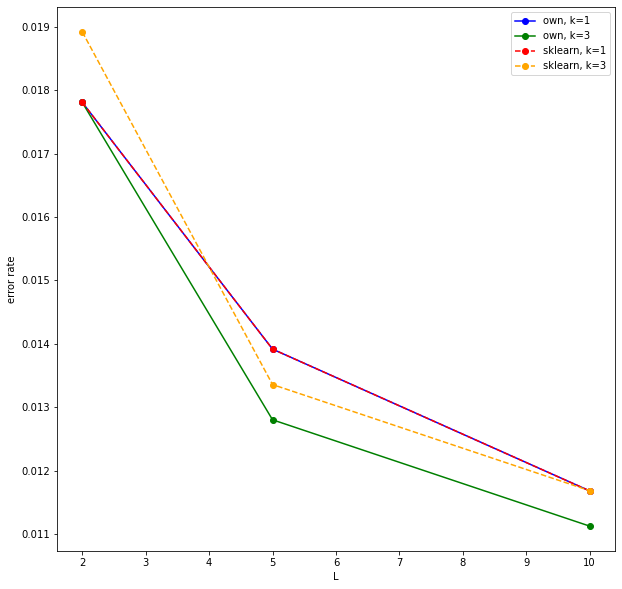

In [206]:
#create plot of the results
L = [2,5,10]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(L,errors_mean_own_1, color="blue", label="own, k=1", marker="o")
ax.plot(L,errors_mean_own_3, color="green", label="own, k=3", marker="o")
ax.plot(L,errors_mean_sklearn_1, color="red", label="sklearn, k=1", linestyle="dashed", marker="o")
ax.plot(L,errors_mean_sklearn_3, color="orange", label="sklearn, k=3", linestyle="dashed", marker="o")
ax.set_xlabel("L")
ax.set_ylabel("error rate")
ax.legend()
plt.show()

We can clearly see that the error is lower for large L (which means large training sets). For k=3 the errir rate seems to be a little bit lower than for k=1